# Distance basis, feature 2 (60 salt bridge distances) 

In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


## load CVs 

In [7]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [8]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

In [9]:
cv_arr.shape

(6580000, 2)

In [13]:
livac_trajs = np.load("../../data/sb_ind100_TICA/livac_trajs.npy", allow_pickle=True)
livac_arr = np.concatenate(livac_trajs)
models_km100 = np.load("../../data/sb_ind100_TICA/models.npy", allow_pickle=True)

In [14]:
with np.load("../../data/raw_feat/ri126_dist.npz", allow_pickle=True) as f:
    ri_trajs = f["arr_0"]
ri_arr = np.concatenate(ri_trajs)
ri_arr.shape

(6580000, 5)

In [15]:
# useful salt bridges
# R223-D129, R226-D129, R229-D129, R226-D186, R229-D186, R232-D186
sb_ids = [36, 42, 48, 46, 52, 58]

In [16]:
cv_arr = np.hstack((cv_arr, data_arr[:, sb_ids], ri_arr, livac_arr))

In [17]:
cv_arr.shape

(6580000, 18)

In [18]:
cv_trajs = np.split(cv_arr, traj_inds)

In [19]:
names = [
    "Distance / $\AA$",
    "Rotation / $^\circ$",
    "R1-D129",
    "R2-D129",
    "R3-D129",
    "R2-D186",
    "R3-D186",
    "R4-D186",
    "R0-I126",
    "R1-I126",
    "R2-I126",
    "R3-I126",
    "R4-I126",
    "iTIC0",
    "iTIC1",
    "iTIC2",
    "iTIC3",
    "iTIC4",
]

# Same states as in 210513 and 210510

In [20]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = livac_arr[:, 1]
sb = cv_arr[:, 2]  # R1-D129

# ellipse centered at (-8.919, -109.9) with radii 0.632 and 9.8 (1 sigma in each direction) for down- state
# take points where TIC 1 > 1.29 and R1-D129 distance > 0.8 nm
dist_ax_down = (dist + 8.919) / 0.632
rot_ax_down = (rot + 109.9) / 9.8
downmin_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (tic1 > 1.29) & (sb > 0.8)
).nonzero()[0]

# ellipse centered at (4.535, 43.7) with radii 0.632 and 2.9 for up+ state
# take points where TIC 1 < -1.25
dist_ax_upp = (dist - 4.535) / 0.632
rot_ax_upp = (rot - 43.7) / 4.0
upplus_ids = (((dist_ax_upp ** 2 + rot_ax_upp ** 2) < 1) & (tic1 < -1.25)).nonzero()[0]

In [22]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[downmin_ids] = False
mask[upplus_ids] = False

# len(**_ids) is number of points in each state
downmin = data_arr[downmin_ids]
upplus = data_arr[upplus_ids]
other = data_arr[mask]

# split CV data
downmin_cvs = cv_arr[downmin_ids]
upplus_cvs = cv_arr[upplus_ids]
other_cvs = cv_arr[mask]

In [23]:
assert (len(downmin) + len(upplus) + len(other)) == len(cv_arr)
print(f"Number of down- structures:  {len(downmin)}")
print(f"Number of up+ structures:   {len(upplus)}")
print(f"Number of other structures: {len(other)}")

Number of down- structures:  727
Number of up+ structures:   52683
Number of other structures: 6526590


# Pairwise distances

In [24]:
print(sklearn.get_config()["working_memory"])

1024


In [25]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [29]:
d_downmin = []
counter = 0.0
tot = len(data_arr)
skip = 1

for chunk in metrics.pairwise_distances_chunked(
    data_arr, downmin[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_downmin.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

2.81% completed
5.61% completed
8.42% completed
11.22% completed
14.03% completed
16.83% completed
19.64% completed
22.45% completed
25.25% completed
28.06% completed
30.86% completed
33.67% completed
36.47% completed
39.28% completed
42.09% completed
44.89% completed
47.70% completed
50.50% completed
53.31% completed
56.11% completed
58.92% completed
61.73% completed
64.53% completed
67.34% completed
70.14% completed
72.95% completed
75.76% completed
78.56% completed
81.37% completed
84.17% completed
86.98% completed
89.78% completed
92.59% completed
95.40% completed
98.20% completed
100.00% completed


In [30]:
print(len(d_downmin), d_downmin[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_downmin_arr = np.reshape(np.concatenate(d_downmin), (-1, 1))
print(d_downmin_arr.shape)
print(np.max(d_downmin_arr[downmin_ids]))
d_downmin_arr[downmin_ids] = 0
print(np.max(d_downmin_arr[downmin_ids]))

print(d_downmin_arr.shape)

36 (184618,)
(6580000, 1)
4.7683716e-07
0.0
(6580000, 1)


In [31]:
np.save("../../data/feat2_dist_dduu/dist_downmin", d_downmin_arr)

## Up+state

In [32]:
d_upp = []
counter = 0.0
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, upplus[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_upp.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.12% completed
0.23% completed
0.35% completed
0.46% completed
0.58% completed
0.70% completed
0.81% completed
0.93% completed
1.05% completed
1.16% completed
1.28% completed
1.39% completed
1.51% completed
1.63% completed
1.74% completed
1.86% completed
1.97% completed
2.09% completed
2.21% completed
2.32% completed
2.44% completed
2.56% completed
2.67% completed
2.79% completed
2.90% completed
3.02% completed
3.14% completed
3.25% completed
3.37% completed
3.48% completed
3.60% completed
3.72% completed
3.83% completed
3.95% completed
4.06% completed
4.18% completed
4.30% completed
4.41% completed
4.53% completed
4.65% completed
4.76% completed
4.88% completed
4.99% completed
5.11% completed
5.23% completed
5.34% completed
5.46% completed
5.57% completed
5.69% completed
5.81% completed
5.92% completed
6.04% completed
6.16% completed
6.27% completed
6.39% completed
6.50% completed
6.62% completed
6.74% completed
6.85% completed
6.97% completed
7.08% completed
7.20% completed
7.32% co

In [33]:
print(len(d_upp), d_upp[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_upp_arr = np.reshape(np.concatenate(d_upp), (-1, 1))
print(d_upp_arr.shape)
print(np.max(d_upp_arr[upplus_ids]))
d_upp_arr[upplus_ids] = 0
print(np.max(d_upp_arr[upplus_ids]))

print(d_upp_arr.shape)

862 (7642,)
(6580000, 1)
0.9523847
0.0
(6580000, 1)


In [34]:
np.save("../../data/feat2_dist_dduu/dist_upplus", d_upp_arr)

## Load save distances 

In [24]:
d_downmin_arr = np.load("../../data/feat1_dduu/dist_downmin.npy")
d_upp_arr = np.load("../../data/feat1_dduu/dist_upplus.npy")

# Smoothing and guess functions 

In [35]:
# make smoothing function
smooth = (d_downmin_arr * d_upp_arr) ** 0.5 / (d_downmin_arr + d_upp_arr)

# make guess
guess_downmin = (d_upp_arr / (d_downmin_arr + d_upp_arr)) ** 2
guess_upp = (d_downmin_arr / (d_downmin_arr + d_upp_arr)) ** 2

# make smoothing 0 at boundaries (dimer and monomer states)
smooth[(mask == 0).flatten()] = 0
# ensure homogeneous boundary conditions for guess
guess_upp[upplus_ids] = 1
guess_upp[downmin_ids] = 0
guess_downmin[downmin_ids] = 1
guess_downmin[upplus_ids] = 0

In [36]:
print(smooth.shape, guess_downmin.shape, guess_upp.shape)

(6580000, 1) (6580000, 1) (6580000, 1)


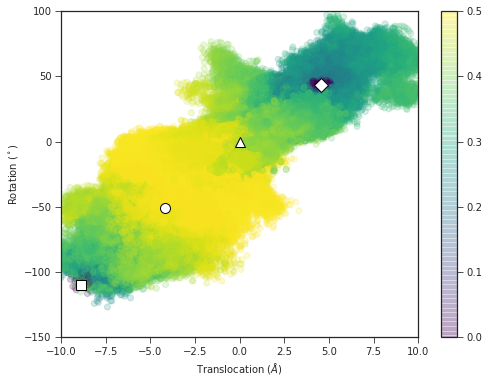

In [37]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=smooth[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

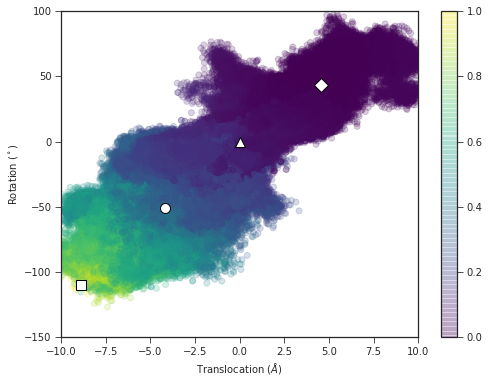

In [38]:
# Plot down state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_downmin[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

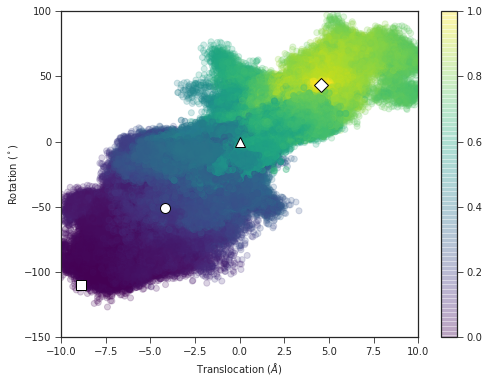

In [39]:
# Plot up+ state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_upp[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

## Construct bases

In [27]:
gc.collect()

148

In [42]:
basis_smooth = smooth * data_arr
print(basis_smooth.shape)
basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.0)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(6580000, 60)


IndexError: index 0 is out of bounds for axis 0 with size 0

In [46]:
U, L, V = np.linalg.svd(basis_smooth, full_matrices=False)
s = np.cumsum(L) / np.sum(L)
# print(s)
basis_white = U @ V
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(6580000, 60)


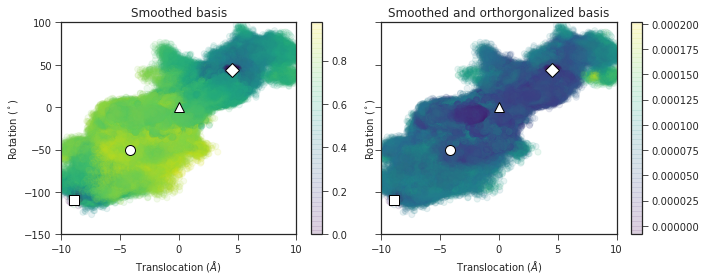

In [47]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
h2 = ax2.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

In [48]:
np.save("../../data/feat2_dist_dduu/basis_white_dduu.npy", basis_white)
np.save("../../data/feat2_dist_dduu/guess_down_dduu.npy", guess_downmin)
np.save("../../data/feat2_dist_dduu/guess_up_dduu.npy", guess_upp)

In [49]:
data_white, L = util.svd_whiten(data_arr, 1)

In [50]:
np.save("../../data/feat2_dist_dduu/data_white.npy", data_white)

## Convert to lists of np arrays 

In [51]:
# basis_white = basis_white[:, 1:]

# basisL = data_trajs
basisF = np.split(basis_white, traj_inds)
guessU = np.split(np.squeeze(guess_upp), traj_inds)
guessD = np.split(np.squeeze(guess_downmin), traj_inds)

# print(len(basisL), basisL[0].shape)
print(len(basisF), basisF[0].shape)
print(len(guessU))
print(len(guessD))

1295 (3000, 60)
1295
1295


In [13]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

# Compute weights 

In [53]:
weights = []
for lag in lags:
    print(f"Computing change of measure for lag {lag}")
    com = extq.dga.reweight(np.split(data_white, traj_inds), lag)
    weights.append(com)

Computing change of measure for lag 1
Computing change of measure for lag 2
Computing change of measure for lag 5
Computing change of measure for lag 10
Computing change of measure for lag 20
Computing change of measure for lag 30
Computing change of measure for lag 40
Computing change of measure for lag 50
Computing change of measure for lag 100
Computing change of measure for lag 200
Computing change of measure for lag 300
Computing change of measure for lag 400
Computing change of measure for lag 500
Computing change of measure for lag 1000
Computing change of measure for lag 2000


In [55]:
np.save("../../data/coms_feat2.npy", weights)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## PMFs 

In [56]:
dens_all = []
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

for (com, lag) in zip(weights, lags):
    print(f"Density for lag {lag}")
    dens_all.append(extq.projection.density2d(dist_trajs, rot_trajs, com, xlim, ylim))

Density for lag 1
Density for lag 2
Density for lag 5
Density for lag 10
Density for lag 20
Density for lag 30
Density for lag 40
Density for lag 50
Density for lag 100
Density for lag 200
Density for lag 300
Density for lag 400
Density for lag 500
Density for lag 1000
Density for lag 2000


/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in log
  
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log
  if __name__ == '__main__':
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1494: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/matplotlib/contour.py:1495: UserWarning: Warning: converting a masked element to nan.
  self.zmin = float(z.min())
/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: No contour levels were found within the

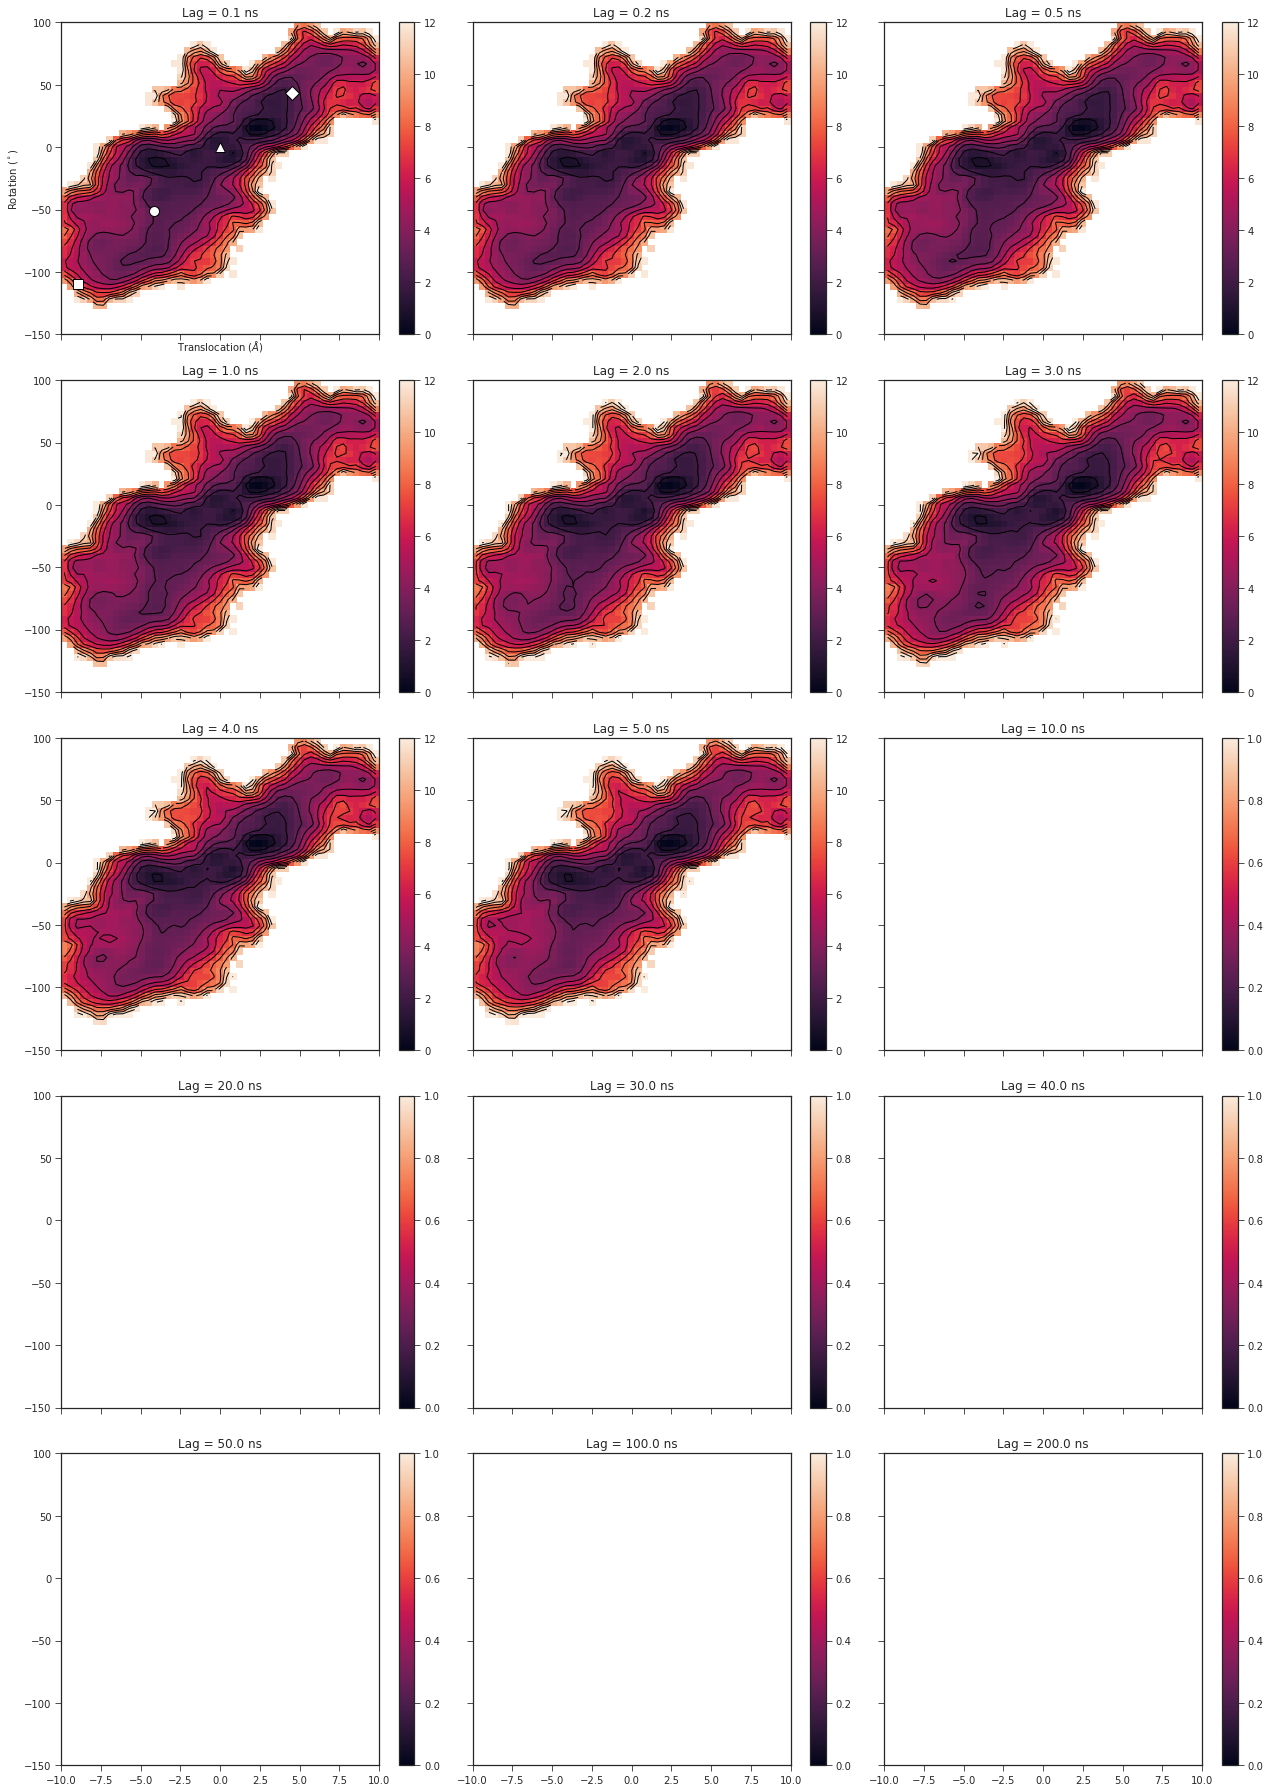

In [58]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, axes = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for i, (lag, ax, pmf) in enumerate(zip(lags, axes.flat, dens_all)):
    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap="rocket", vmax=12)
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
        linewidths=1,
    )
    ax.set_title(f"Lag = {lag * 0.1} ns")

util.format_cvs(axes[0][0])
f.tight_layout()
plt.savefig("../../fig/pmfs/feat2_pmfs_ds", dpi=400)

# All committors 

In [59]:
in_domain = np.split(mask, traj_inds)
q_downup, qb_downup, q_updown, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 30
Calculating committors for lag 40
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 300
Calculating committors for lag 400
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000


In [60]:
np.save("../../data/feat2_dist_dduu/q_du_feat2.npy", q_downup)
np.save("../../data/feat2_dist_dduu/qb_du_feat2.npy", qb_downup)
np.save("../../data/feat2_dist_dduu/q_ud_feat2.npy", q_updown)
np.save("../../data/feat2_dist_dduu/qb_ud_feat2.npy", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [11]:
q_downup = np.load("../../data/feat2_dist_dduu/q_du_feat2.npy", allow_pickle=True)
qb_downup = np.load("../../data/feat2_dist_dduu/qb_du_feat2.npy", allow_pickle=True)
q_updown = np.load("../../data/feat2_dist_dduu/q_ud_feat2.npy", allow_pickle=True)
qb_updown = np.load("../../data/feat2_dist_dduu/qb_ud_feat2.npy", allow_pickle=True)

## Activation

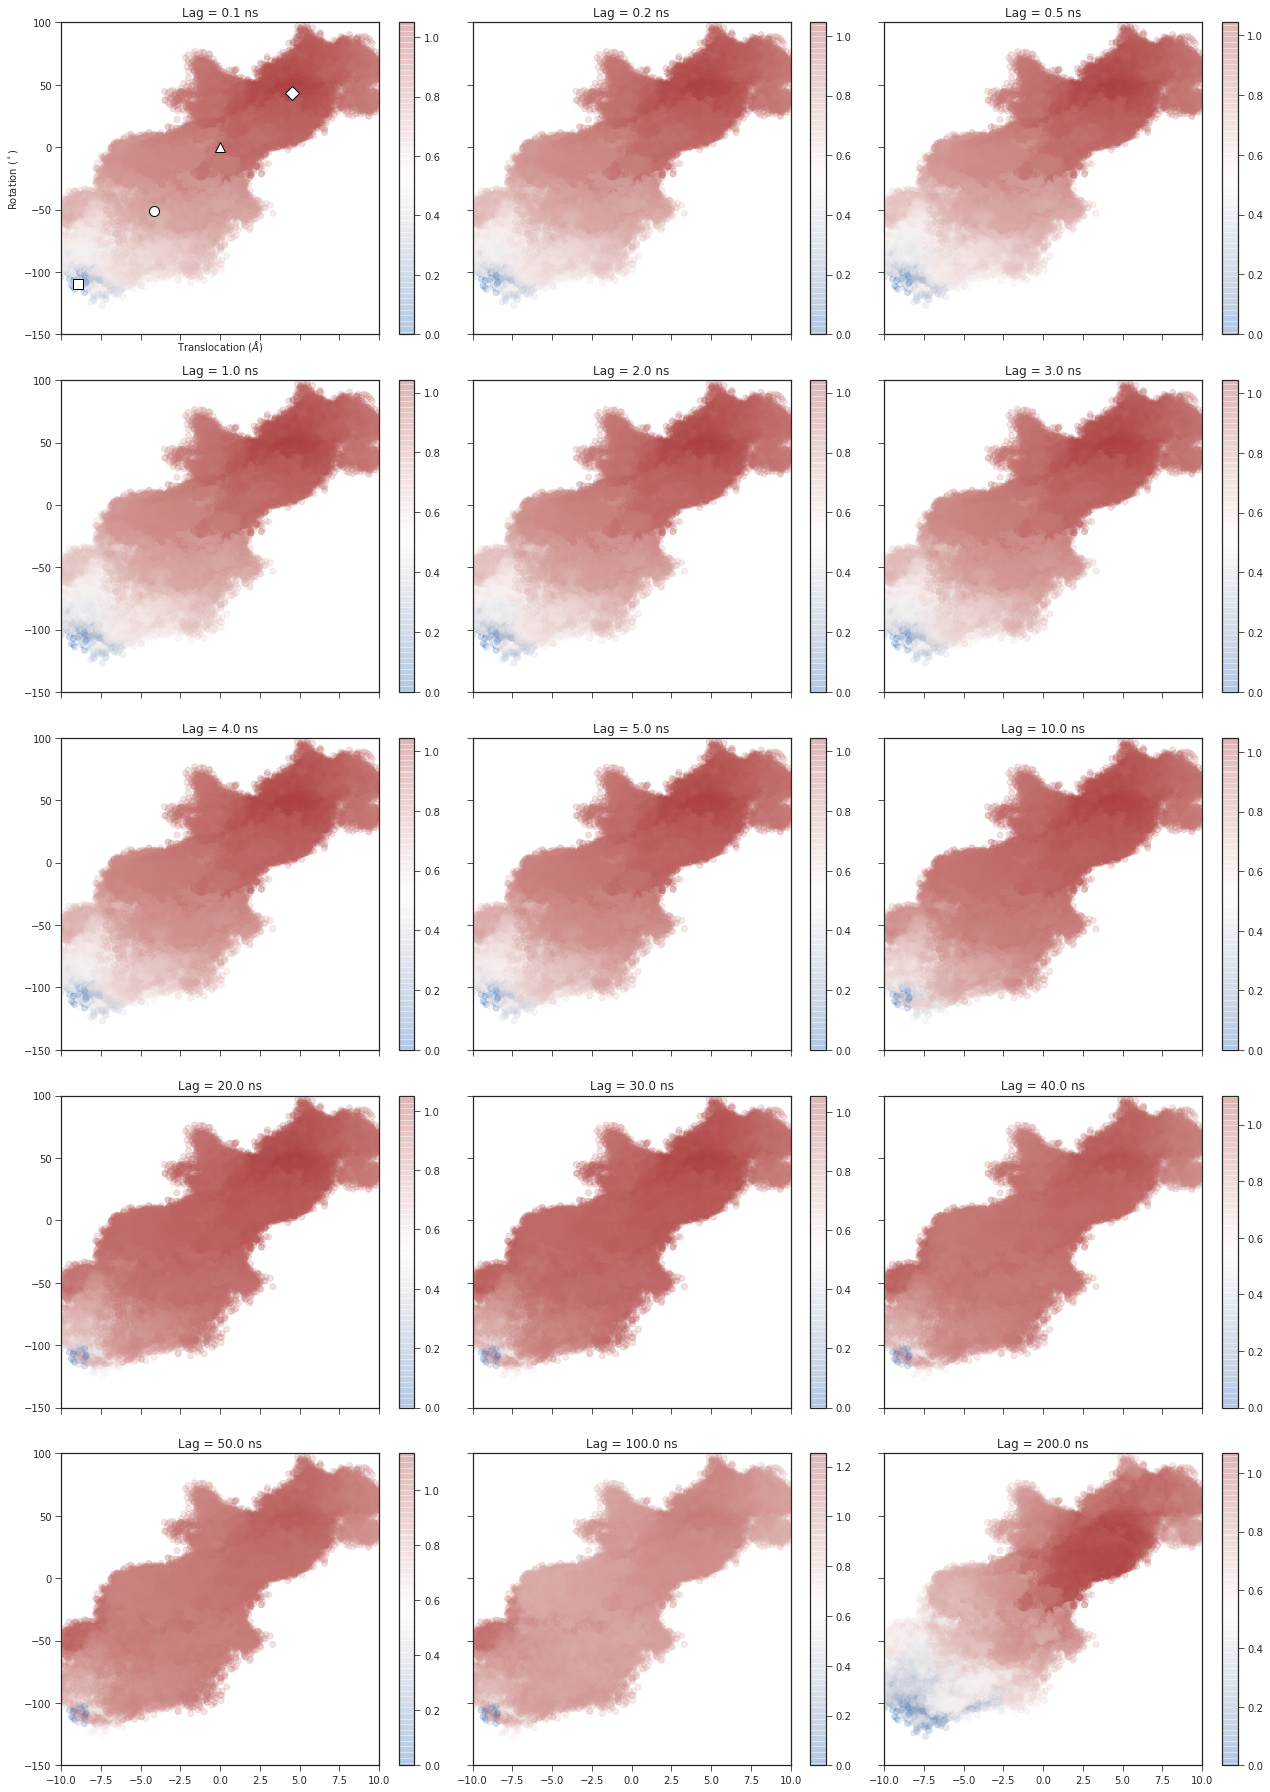

In [61]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
util.format_cvs(axs[0][0])

f.tight_layout()
plt.savefig("../../fig/committors/qf_feat2dist_activation_alllags_ds", dpi=400)

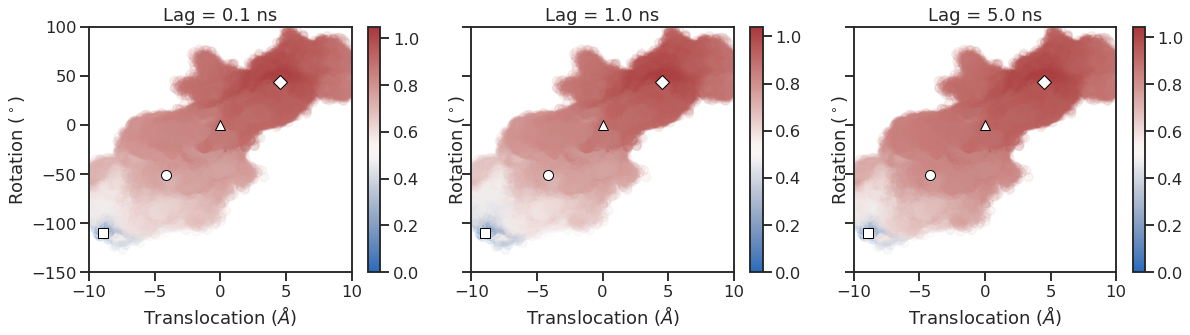

In [18]:
sns.set_context("talk")
f, axs = plt.subplots(1, 3, figsize=(17, 5), sharex=True, sharey=True)
# compare 0.1, 1.0, and 5.0 ns lags
lag_inds = (0, 3, 7)
for lag, q, ax in zip(
    [lags[i] for i in lag_inds], [q_downup[i] for i in lag_inds], axs.flatten()
):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.1
    )
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)
f.tight_layout()
plt.savefig("../../fig/talks/qf_feat2dist_activation_3lags_ds", dpi=300)

## Dectivation

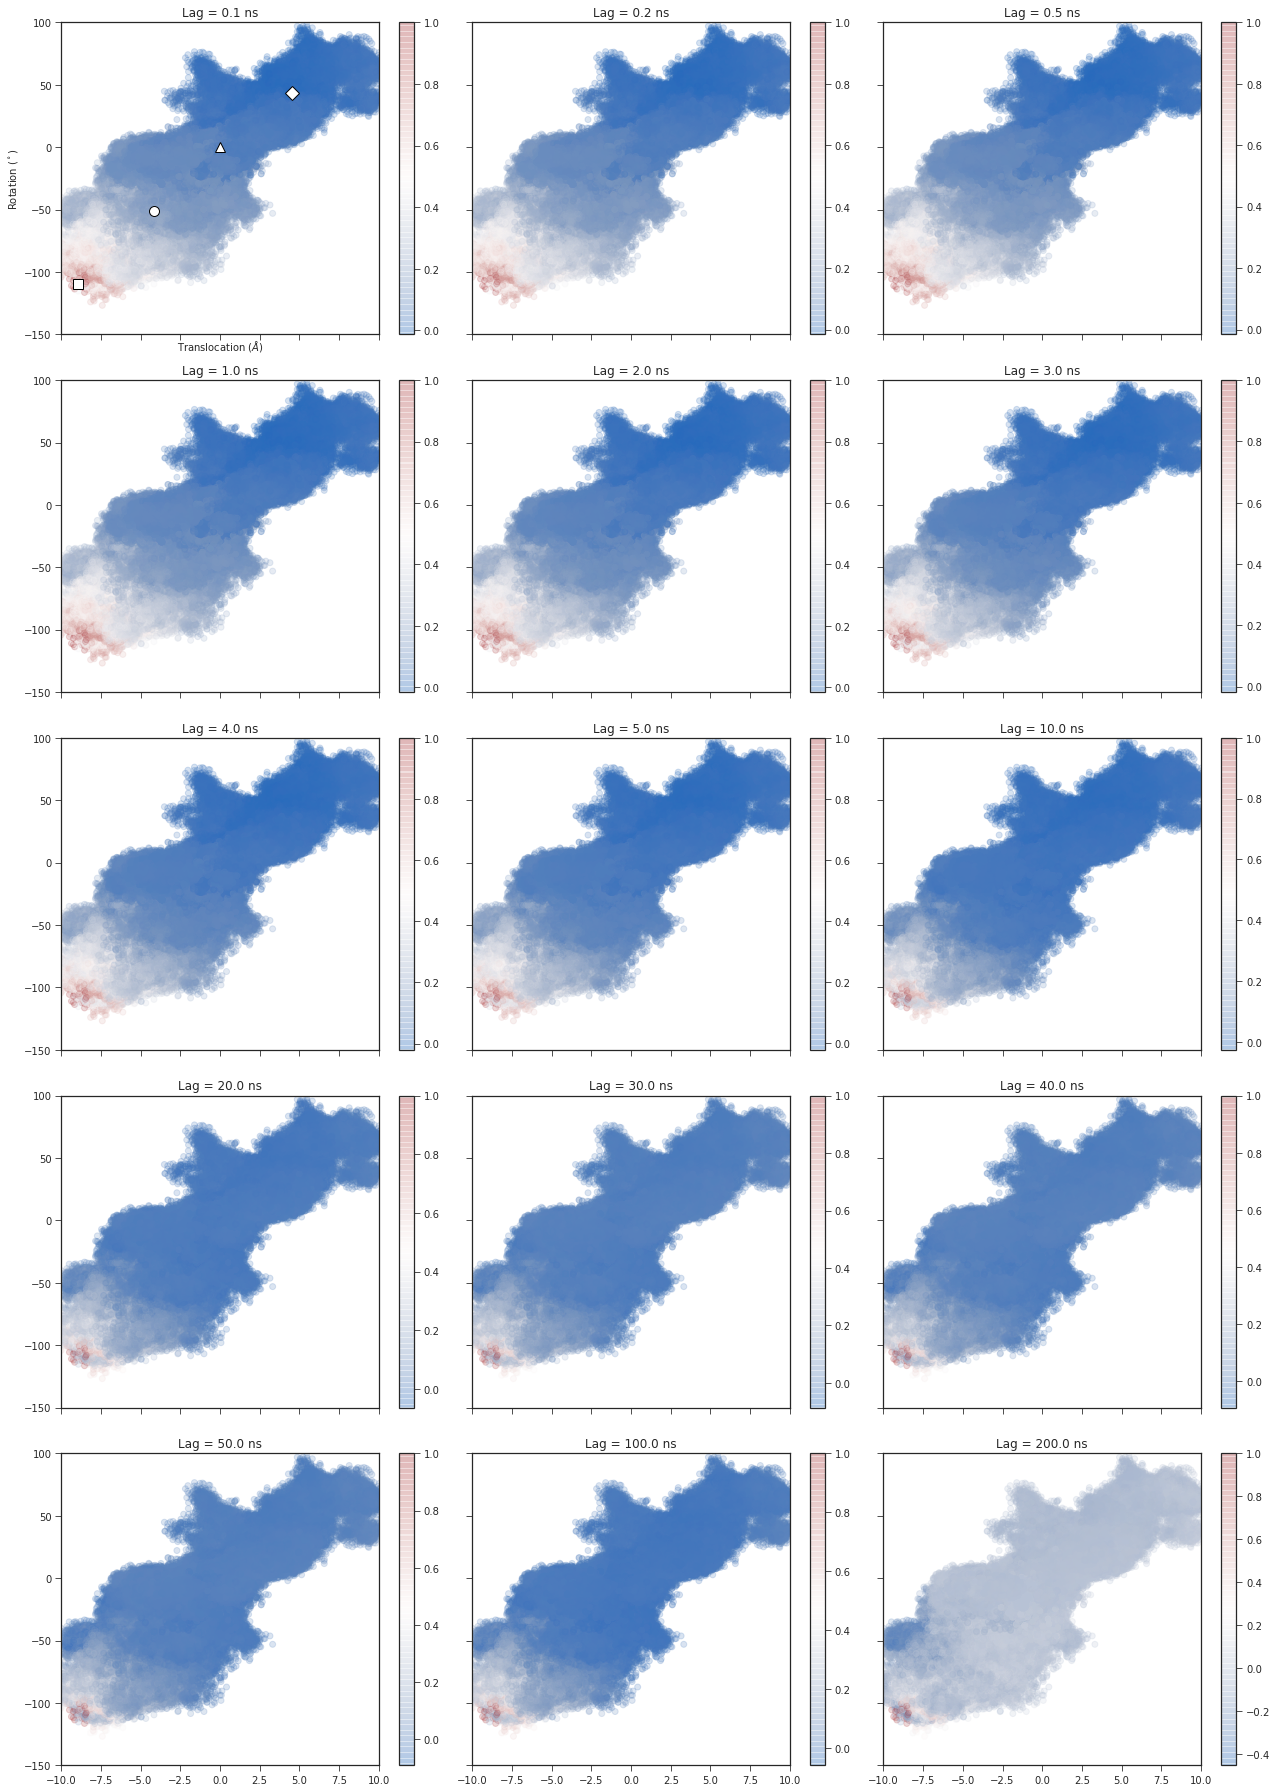

In [62]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_updown, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
util.format_cvs(axs[0][0])

f.tight_layout()
# plt.savefig('../../fig/committors/qf_feat2dist_activation_alllags_ds', dpi=400)